In [15]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


def corners_unwarp(cb_image, nx, ny, mtx, dist):
    undistorted = cv2.undistort(cb_image, mtx, dist, None, mtx)
    gray = cv2.cvtColor(undistorted, cv2.COLOR_RGB2GRAY)
    image_w, image_h = gray.shape[1], gray.shape[0]

    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if not ret:
        print('WARNING: Failed to detect corners for image {} with nx {} and ny {}'.format(image_fname, nx, ny))
        return None, None

    cv2.drawChessboardCorners(undistorted, (nx, ny), corners, ret)

    src_tl = corners[0][0]
    src_tr = corners[nx-1][0]
    src_br = corners[-1][0]
    src_bl = corners[-nx][0]

    offset = 200
    dst_tl = [offset, offset]
    dst_tr = [image_w-offset, offset]
    dst_br = [image_w-offset, image_h-offset]
    dst_bl = [offset, image_h-offset]

    src = np.float32([src_tl, src_tr, src_br, src_bl])
    dst = np.float32([dst_tl, dst_tr, dst_br, dst_bl])

    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undistorted, M, gray.shape[::-1], flags=cv2.INTER_LINEAR)

    return warped, M


def calibrate(fnames, nx, ny, img_w, img_h, verbose=False):
    objpoints = []
    imgpoints = []

    objp = np.zeros((ny * nx, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    if verbose:
        print('Calibration started...')

    for fname in fnames:
        if verbose:
            print('Finding chesshboard in {}'.format(fname))
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret:
            if verbose:
                print('Found chessboard in {}'.format(fname))
            imgpoints.append(corners)
            objpoints.append(objp)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (img_w, img_h), None, None)
    if not ret:
        print('WARNING: Failed to calibrate camera')
        return None, None

    if verbose:
        print('Calibration succeeded...')

    return mtx, dist


def hls_select(img, chan, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    channel_s = hls[:,:,chan]
    binary = np.zeros_like(channel_s)
    binary[(channel_s > thresh[0]) & (channel_s <=thresh[1])] = 1
    return binary


def abs_thresh(img, ksize=3, thresh=(0,255), orient='x'):
    axis = 0 if orient == 'x' else 1
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    raw_sobel = cv2.Sobel(gray, cv2.CV_64F, 1-axis, axis, ksize=ksize)
    abs_sobel = np.absolute(raw_sobel)
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output


def mag_thresh(img, ksize=3, thresh=(0,255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)
    mag_sobel = np.sqrt(np.square(sobel_x) + np.square(sobel_y))
    scaled_sobel = np.uint8(255 * mag_sobel / np.max(mag_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <=thresh[1])] = 1
    return binary_output


def dir_thresh(img, ksize=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    abs_sobel_x = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize))
    abs_sobel_y = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize))
    dir_sobel = np.arctan2(abs_sobel_y, abs_sobel_x)
    binary_output = np.zeros_like(dir_sobel)
    binary_output[(dir_sobel >= thresh[0]) & (dir_sobel <= thresh[1])] = 1
    return binary_output


def window_img_with_fits(img, l_fit, r_fit, n_windows=9, margin=100):

    # All non-zero pixel locations
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    l_lane_idxs = ((nonzerox > (l_fit[0]*(nonzeroy**2) + l_fit[1]*nonzeroy + l_fit[2] - margin)) & (nonzerox < (l_fit[0]*(nonzeroy**2) + l_fit[1]*nonzeroy + l_fit[2] + margin)))
    r_lane_idxs = ((nonzerox > (r_fit[0]*(nonzeroy**2) + r_fit[1]*nonzeroy + r_fit[2] - margin)) & (nonzerox < (r_fit[0]*(nonzeroy**2) + r_fit[1]*nonzeroy + r_fit[2] + margin)))

    lx = nonzerox[l_lane_idxs]
    ly = nonzeroy[l_lane_idxs]
    rx = nonzerox[r_lane_idxs]
    ry = nonzeroy[r_lane_idxs]

    new_l_fit = np.polyfit(ly, lx, 2)
    new_r_fit = np.polyfit(ry, rx, 2)


def find_fits(img, l_fit=None, r_fit=None, n_windows=9, margin=100, minpix=50, draw=False):

    # All non-zero pixel locations
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Indices found for pixels on lane lines
    l_lane_idxs = []
    r_lane_idxs = []

    # Output to be drawn
    out_img = None
    if draw:
        out_img = np.dstack((img, img, img))*255
    
    # If we are passed in fits from last frame, then skip sliding window
    reuse_fits = not (l_fit is None or r_fit is None)

    if reuse_fits:
        l_lane_idxs = ((nonzerox > (l_fit[0]*(nonzeroy**2) + l_fit[1]*nonzeroy + l_fit[2] - margin)) & (nonzerox < (l_fit[0]*(nonzeroy**2) + l_fit[1]*nonzeroy + l_fit[2] + margin)))
        r_lane_idxs = ((nonzerox > (r_fit[0]*(nonzeroy**2) + r_fit[1]*nonzeroy + r_fit[2] - margin)) & (nonzerox < (r_fit[0]*(nonzeroy**2) + r_fit[1]*nonzeroy + r_fit[2] + margin)))
    else:
        # Histogram of bottom half of img
        histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
        # Left and right x-coord at the base, and window height
        midpoint = histogram.shape[0] // 2
        xl_base = np.argmax(histogram[:midpoint])
        xr_base = np.argmax(histogram[midpoint:]) + midpoint
        window_h = img.shape[0] // n_windows
        # Sliding window loop
        xl_current = xl_base
        xr_current = xr_base
        for window in range(n_windows):
            # Window boundaries
            win_y_lo = img.shape[0] - window_h * (window + 1)
            win_y_hi = img.shape[0] - window_h * window
            # Left lane window
            win_xl_lo = xl_current - margin
            win_xl_hi = xl_current + margin
            # Right lane window
            win_xr_lo = xr_current - margin
            win_xr_hi = xr_current + margin
            # Find non-zero pixels within window
            good_l_idxs = ((nonzeroy >= win_y_lo) & (nonzeroy < win_y_hi) & (nonzerox >= win_xl_lo) & (nonzerox < win_xl_hi)).nonzero()[0]
            good_r_idxs = ((nonzeroy >= win_y_lo) & (nonzeroy < win_y_hi) & (nonzerox >= win_xr_lo) & (nonzerox < win_xr_hi)).nonzero()[0]
            # Append to list of found indices
            l_lane_idxs.append(good_l_idxs)
            r_lane_idxs.append(good_r_idxs)
            # If found more than minpix pixels, recenter next window on their mean position
            if len(good_l_idxs) > minpix:
                xl_current = np.int(np.mean(nonzerox[good_l_idxs]))
            if len(good_r_idxs) > minpix:
                xr_current = np.int(np.mean(nonzerox[good_r_idxs]))
            # Draw window on output
            if draw:
                cv2.rectangle(out_img,(win_xl_lo,win_y_lo),(win_xl_hi,win_y_hi),(0,0,255), 5)
                cv2.rectangle(out_img,(win_xr_lo,win_y_lo),(win_xr_hi,win_y_hi),(255,0,0), 5)
        # Flatten
        l_lane_idxs = np.concatenate(l_lane_idxs)
        r_lane_idxs = np.concatenate(r_lane_idxs)

    # Gather all pixel locations on lane lines
    lx = nonzerox[l_lane_idxs]
    ly = nonzeroy[l_lane_idxs]
    rx = nonzerox[r_lane_idxs]
    ry = nonzeroy[r_lane_idxs]

    # Fit polynomial for each lane
    new_l_fit = np.polyfit(ly, lx, 2)
    new_r_fit = np.polyfit(ry, rx, 2)

    if draw:
        # Draw pixels of detected lane lines
        out_img[nonzeroy[l_lane_idxs], nonzerox[l_lane_idxs]] = [0,0,255]
        out_img[nonzeroy[r_lane_idxs], nonzerox[r_lane_idxs]] = [255,0,0]
        # Draw fitted lane lines
        ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
        l_fit_x = new_l_fit[0] * ploty ** 2 + new_l_fit[1] * ploty + new_l_fit[2]
        r_fit_x = new_r_fit[0] * ploty ** 2 + new_r_fit[1] * ploty + new_r_fit[2]
        # window_img, used to add a weighted layer to out_img
        window_img = np.zeros_like(out_img)
        l_line_window1 = np.array([np.transpose(np.vstack([l_fit_x - margin, ploty]))])
        l_line_window2 = np.array([np.flipud(np.transpose(np.vstack([l_fit_x + margin, ploty])))])
        l_line_pts = np.hstack((l_line_window1, l_line_window2))
        r_line_window1 = np.array([np.transpose(np.vstack([r_fit_x - margin, ploty]))])
        r_line_window2 = np.array([np.flipud(np.transpose(np.vstack([r_fit_x + margin, ploty])))])
        r_line_pts = np.hstack((r_line_window1, r_line_window2))
        cv2.fillPoly(window_img, np.int_([l_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([r_line_pts]), (0,255, 0))
        out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        # Plot the above two lines
        plt.imshow(out_img)
        plt.plot(l_fit_x, ploty, color='yellow')
        plt.plot(r_fit_x, ploty, color='yellow')
        plt.xlim(0, img_w)
        plt.ylim(img_h, 0)
    
    return new_l_fit, new_r_fit, out_img
    

# Calculate calibration parameters
cb_fnames = glob.glob('camera_cal/calibration*.jpg')
nx, ny = 9, 6
img_w, img_h = 1280, 720
mtx, dist = calibrate(cb_fnames, nx, ny, img_w, img_h, verbose=False)

# Calculate perspective transformation matrix
dst_offset = 400
src_bl, src_br, src_tl, src_tr = [190,720], [1090,720], [600,440], [680,440]
dst_bl, dst_br, dst_tl, dst_tr = [dst_offset,img_h], [img_w-dst_offset,img_h], [dst_offset,0], [img_w-dst_offset,0]
psp_src = np.float32([src_tl, src_tr, src_br, src_bl])
psp_dst = np.float32([dst_tl, dst_tr, dst_br, dst_bl])
M = cv2.getPerspectiveTransform(psp_src, psp_dst)

def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)
def perspective(img):
    return cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

def pipeline(img, thresh_f, draw=False):
    return find_fits(perspective(thresh_f(undistort(img))), draw=draw)

print('Initialized')


Initialized


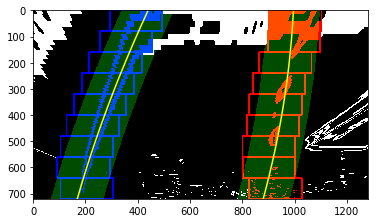

In [19]:
#img = mpimg.imread('test_images/test3.jpg')
#plt.imshow(pipeline(img, lambda x: x))

def thresh_img(img):
    return mag_thresh(img, ksize=9, thresh=(30,100))

l_fit, r_fit, _ = pipeline(mpimg.imread('test_images/test1.jpg'), thresh_img, True)
